# <center> HUMAN ACTIVITY RECOGNITION

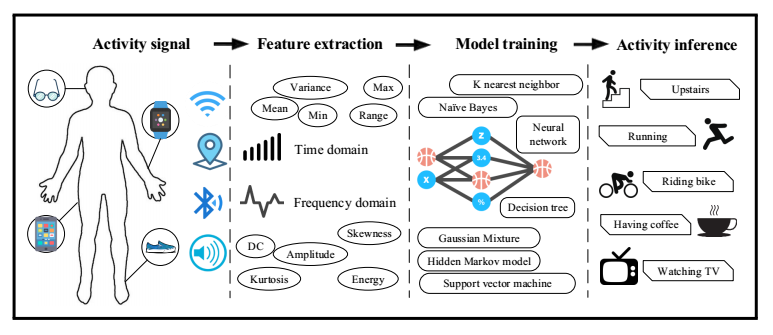

In [1]:
# Human Activity Image
from IPython.display import Image
Image(filename='Human Activities.png',width=900)

__Deep learning model - LSTM's__

The model will be carried out on raw-time series data.
We have 9 time series files:
1. 3 __body_accelerometer_data__ files,
2. 3 __body_gyro_data__ files,
3. 3 __total_accelerometer_data__ files


We will feed the raw time series data itself into the model.

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Activities are the class labels and we have a multi-class classification problem.
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
# Importing keras libraries

import warnings
warnings.simplefilter("ignore")
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [18]:
# Initializing parameters
epochs = 30
batch_size = 16

In [19]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [20]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [21]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [22]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(16,return_sequences=True, input_shape=(timesteps, input_dim)))
# Another layer
model.add(LSTM(16))
# Add BN
model.add(BatchNormalization())
# Adding a dropout layer
model.add(Dropout(0.8))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 16)           1664      
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                2112      
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 102       
Total params: 3,942
Trainable params: 3,910
Non-trainable params: 32
_________________________________________________________________


In [23]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [24]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 98s 13ms/step - loss: 1.6737 - acc: 0.3572 - val_loss: 0.9923 - val_acc: 0.6081
Epoch 2/30
7352/7352 [==============================] - 90s 12ms/step - loss: 1.1088 - acc: 0.5169 - val_loss: 0.7525 - val_acc: 0.6440
Epoch 3/30
7352/7352 [==============================] - 90s 12ms/step - loss: 0.9323 - acc: 0.5978 - val_loss: 0.8233 - val_acc: 0.6407
Epoch 4/30
7352/7352 [==============================] - 90s 12ms/step - loss: 0.8080 - acc: 0.6574 - val_loss: 0.5021 - val_acc: 0.8066
Epoch 5/30
7352/7352 [==============================] - 92s 12ms/step - loss: 0.7276 - acc: 0.6836 - val_loss: 0.4306 - val_acc: 0.8225
Epoch 6/30
7352/7352 [==============================] - 91s 12ms/step - loss: 0.6694 - acc: 0.7047 - val_loss: 0.6727 - val_acc: 0.7319
Epoch 7/30
7352/7352 [==============================] - 91s 12ms/step - loss: 0.6361 - acc: 0.7184 - val_loss: 0.3570 - val_acc: 0.8663


In [25]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 536        0         0        0                   0   
SITTING                  7      411        70        2                   0   
STANDING                 0      105       423        3                   0   
WALKING                  0        0         0      481                   4   
WALKING_DOWNSTAIRS       0        0         0        5                 410   
WALKING_UPSTAIRS         0        0         0       33                   4   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             1  
SITTING                            1  
STANDING                           1  
WALKING                           11  
WALKING_DOWNSTAIRS                 5  
WALKING_UPSTAIRS                 434  


In [26]:
# Evaluating test data
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 6s 2ms/step


In [27]:
# Log loss and accuracy on test data
score

[0.3088785500611205, 0.9144893111638955]

### 7. Insights & Conclusion


In line with our objective we have predicted human activities from sensors using various machine learning models and have also tried out with one simple deep learning model.

While observing the outputs from t-sne plot and confusion matrix of various machine learning models one pattern is evident that is, there is a confusion while classifying standing and sitting class,that's why we have a high precision and recall rates on non-diagonal cells(read as standing and sitting). Apart from this our model fairly classifies other classes with good accuracy. 

Also when we observe the results of the models, our linear models are doing good then our non-linear models like decision tree,random forest. So it's good to stick with our linear models.

One way to avoid this confusion of classification between standing & sitting classes is we could get a feedback from __DOMAIN EXPERT__. Probably he/she could give us feedback on this issue. We could come up with new features that could solve the problem.

I tried out deep learning model because, they can automatically engineer new features for us. But when we observe the output of deep learning model, even they struggle to classify these two classes. 

Final conclusion would be use linear models like logistic regression, linear svm. Also with the help of domain expert we can further featurize the data.